# PyTorch - Unsupervised Learning - 3
 >__Created__: June 2020, Tallahassee, USA 
 
## Introduction
We consider the task of __unsupervised__ clustering the the $28 \times 28 = 784$ gray scale images of handwritten digits in the [MNIST](http://yann.lecun.com/exdb/mnist) data set. We do this using an autoencoder, which implements the identity map $f: x \rightarrow x$, but with a crucial twist. The map $f$ is implemented in two steps: first the map $e: x \rightarrow z$ followed by the map $d: z \rightarrow x$, where the space $z \equiv (z_1, z_2) \in R^2$, often referred to as a __latent__ space, is of much lower dimensionality than the 784-D space of the images. We use the quadratic loss between the inputs to the __encoder__ function $z = e(x)$
and the outputs of the __decoder__ function $x = d(z)$. Recall that the quadratic loss leads to the result
\begin{align}
    f(x) & = \int y \, p(y \, | \, x) \, dy,
\end{align}
where $x$ are the inputs, here images, and $y$ are the targets. But, since $y = x$, $p(y \, | \, x) = \delta(y - x)$, which implies that a sufficiently flexible autoencoder $f(x)$ provides an *unbiased* estimate of its inputs, via its latent space.

The data contains $T = 60,000$ images for training and 10,000 images for testing. Following good practice, we split the training data into a set for training and another for validating the training. The test data are not used in the training.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
import imageio as im

#  a function to load and save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 20
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load Images

If the files are do not exist, go to the datasets folder and run the notebook prepare_mnist_data.ipynb to create them.

In [3]:
train_x, train_y = jb.load('../datasets/mnist_train.pkl.gz')
test_x,  test_y  = jb.load('../datasets/mnist_test.pkl.gz')

In [4]:
def plotImages(x, n_rows=8, n_cols=8, f_size=(4, 4)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

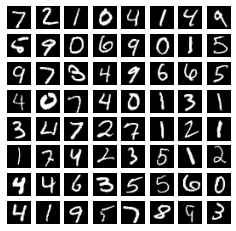

In [5]:
plotImages(test_x[:64])

### Prepare training and validation sets

In [6]:
train_fraction = 0.9   # fraction of data used for training

M = int(train_fraction*len(train_x))
train_x, val_x = train_x[:M], train_x[M:]
train_y, val_y = train_y[:M], train_y[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        54000
number of images for validation:       6000
number of images for testing:         10000


### Define autoencoder class
Here, for simplicity, we use the __Sequential__ class to define the structure of the model.

In [44]:
class autoencoder(nn.Module):
    
    def __init__(self):
        # initialize the base (that is, parent class)
        super(autoencoder, self).__init__()
        
        Nx = 28*28    # dim of input space
        self.y = None # to cache results of encoder
        
        self.encoder = nn.Sequential(
            nn.Linear(Nx, 200), nn.ReLU(),
            nn.Linear(200, 50), nn.ReLU(),
            nn.Linear(50,  50), nn.ReLU(),
            nn.Linear(50,  10), nn.ReLU(),
            nn.Linear(10,   2)) # dim of latent space
        
        self.decoder = nn.Sequential(
            nn.Linear(2,   10), nn.ReLU(),
            nn.Linear(10,  50), nn.ReLU(),
            nn.Linear(50,  50), nn.ReLU(),
            nn.Linear(50, 200), nn.ReLU(),
            nn.Linear(200, Nx))

    def z(self):
        return self.y.detach().numpy()
    
    def forward(self, x):
        self.y = self.encoder(x) # cache result of encoder.
        y      = self.decoder(self.y)
        return y

### Get next batch of images
Get a sample from the training set of size $n\_batch$

In [45]:
class Batch:
    def __init__(self, x, size):
        self.x     = x
        self.size  = size
        self.n     = len(self.x)
        
    def __del__(self):
        pass
    
    def next(self):
        # the numpy function choice(length, number)
        # selects at random "number" integers from the range [0, length-1]
        rows = rnd.choice(self.n, self.size)
        return self.x[rows]

### Set up training sequence

In [67]:
def train(model, optimizer, avloss, batch):
    # set mode to training in case the model includes training specific 
    # operations such as dropout. (The method, train(), sets the boolean 
    # self.training to True)
    model.train()
    
    # Get a batch of images
    batch_x = batch.next()
        
    # Convert the numpy array batch_x to tensor types. The later is 
    # the expected type into models and the loss functions. (Note: 
    # a loss function, as used in ML is really the average loss or 
    # the empirical risk function.)
    #
    # A PyTorch tensor type is the magic that permits automatic 
    # differentiation with respect to parameters. However, we do not
    # need derivatives with respect to the images, so we disable them.
    with torch.no_grad(): # no need to compute gradients wrt. x
        x = torch.from_numpy(batch_x)     

    # compute the output of the model for the batch of images x
    outputs = model(x)
    
    # compute a noisy approximation to the average loss
    loss    = avloss(outputs, x)
    
    # use automatic differentiation to compute a noisy approximation
    # of the local gradient. The noisy gradient increases the probability
    # that the optimizer will, by chance, exit from a local minimum. 
    # In principle, if we knew we were approaching a good approximation to 
    # the global minimum, it would make sense to reduce the noise in the 
    # gradient by increasing the batch size.)
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    
    # Finally, advance one step in the direction of steepest descent,
    # using the noisy local gradient. 
    optimizer.step()       # move one step
        
def validate(model, train_x, val_x):
    # make sure we set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x
        # compute accuracy using training sample
        x = torch.from_numpy(train_x)
        o = model(x)
        acc_t = avloss(o, x)
  
        # compute accuracy using validation sample
        x = torch.from_numpy(val_x)
        o = model(x)
        acc_v = avloss(o, x)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, avloss, 
               train_x, val_x,
               n_iterations, batch):

    step = 100
    xx   = []
    yy_t = []
    yy_v = []
    for ii in range(n_iterations):
        
        # do one step of minimization
        train(model, optimizer, avloss, batch)
    
        if ii % step == 0:
            acc_t, acc_v = validate(model, train_x, val_x) 
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

plot loss function vs. iteration

In [68]:
def plot(xx, yy_t, yy_v):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # adjust y limits
    ax.set_xlim((0, xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')

    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('loss', fontsize=16)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='lower right')
    
    fig.tight_layout()
    plt.show()

### Instantiate an autoencoder and an optimizer

In [87]:
model     = autoencoder()
avloss    = nn.MSELoss()
lr_rate   = 1.e-3
wt_decay  = 1.e-9
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr_rate, 
                             weight_decay=wt_decay)

### Now train!

     59900	    0.0341	    0.0341

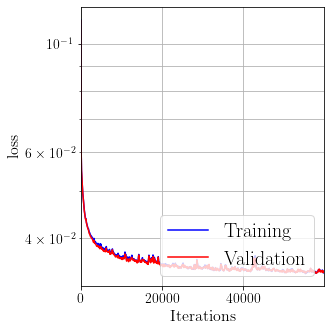


done!


In [88]:
n_iter   = 60000    # number of iterations
n_batch  =   256    # N = n_batch
batch    = Batch(train_x, n_batch)
xx, yy_t, yy_v = trainModel(model, optimizer, avloss,
                            train_x, val_x, n_iter, batch) 
plot(xx, yy_t, yy_v)

print("\ndone!")
torch.save(model.state_dict(), 'mnist_autoencoder.pth')

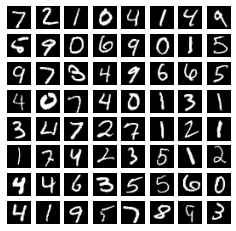

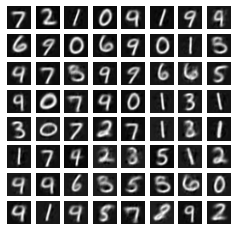

In [90]:
model.eval()  # go to evaluation mode.
x  = torch.from_numpy(test_x)
o  = model(x)
z  = model.z()

o  = o.detach().numpy()
plotImages(test_x[:64])
plotImages(o[:64])

### Plot distribution in 2-D latent space

In [91]:
def normalize(x):
    mean = x.mean()
    std  = x.std()
    return (x - mean)/std

In [92]:
def plotResults(x, y, t, 
                xmin=-2.0, xmax= 2.0, 
                ymin=-2.0, ymax= 2.0,
                ftsize=FONTSIZE):

    # set size of figure
    plt.figure(figsize=(5, 5))
    
    # annotate axes
    plt.xlabel('$z_1$', fontsize=ftsize)
    plt.ylabel('$z_2$', fontsize=ftsize)

    xaxis_lim = np.array([xmin, xmax])
    yaxis_lim = np.array([ymin, ymax])

    colors = ['grey', 'lightcoral', 'red', 'darkorange', 
              'gold', 'green', 'blue', 
              'royalblue', 'indigo', 'violet']
    kolors = [colors[i] for i in t]
    plt.scatter(normalize(x), normalize(y), c=kolors, lw=0, s=8)
    plt.xlim(xaxis_lim)
    plt.ylim(yaxis_lim)
    plt.savefig('mnist_autoencoder_results03.pdf')
    
    #fig.tight_layout()
    plt.show()

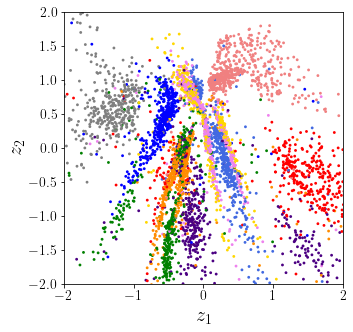

In [93]:
N  = 5000
z1 = z[:,0][:N]
z2 = z[:,1][:N]
y  = test_y[:N]

plotResults(z1, z2, y)